In [131]:
import requests

# Variabel yang diperlukan
protocol = "https"
ip_or_domain = "platform.antares.id"
port = "8443"
cse_id = "antares-id"
cse_name = "antares-cse"
application_name = "AMIModule"
device_name = "LoRa_Gateway"
access_key = "fbcc54e8fa44769a:601102b2dae28971"

# Membangun URL
url = f"https://platform.antares.id:8443/~/antares-cse/antares-id/{application_name}/{device_name}?lim=50000&fu=1&drt=2&ty=4"
# irl = f"{protocol}://{ip_or_domain}:{port}/~/{cse-id}/{cse-name}/{application-name}/{device-name}?lim=50000&fu=1&drt=2&ty=4"
# Header yang diperlukan
headers = {
    "Accept": "application/json",
    "X-M2M-Origin": access_key,
    "Content-Type": "application/json"
}

# Mengirim GET request
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Memeriksa apakah ada error dalam respons

    # Mengambil data JSON dari respons
    data = response.json()
    print("Raw JSON yang diterima")
    # print(data)

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except requests.exceptions.RequestException as err:
    print(f"Error occurred: {err}")


Raw JSON yang diterima


In [132]:
import pandas as pd
import json
from datetime import datetime

def convert_to_dataframe(json_data):
    if not json_data or "m2m:list" not in json_data:
        print("Invalid JSON structure")
        return pd.DataFrame()
    
    records = []
    for item in json_data["m2m:list"]:
        cin = item.get("m2m:cin", {})
        con_raw = cin.get("con", "{}")

        # Bersihkan karakter kontrol yang mungkin menyebabkan error
        con_raw = con_raw.replace("\n", "").replace("\t", "").replace("\r", "")

        try:
            con_data = json.loads(con_raw, strict=False)  # Gunakan strict=False untuk mengabaikan error karakter kontrol
            ct_raw = cin.get("ct", "")  # Tambah kolom received_at_server
            formatted_ct = datetime.strptime(ct_raw, "%Y%m%dT%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
            con_data["received_at_server"] = formatted_ct # Tambah kolom received_at_server
            
            records.append(con_data)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            print(f"Problematic data: {con_raw}")

    return pd.DataFrame(records)

df = convert_to_dataframe(data)

In [133]:
df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server
0,08:D1:F9:35:B5:48,2025-03-13 23:02:16,2025-03-13 23:02:32,2025-03-13 23:02:32.862,-115,mqtt,229.50,0.26,43.10,3.36,433000000.0,0.73,2025-03-13 23:02:32
1,08:D1:F9:35:B5:48,2025-03-13 23:02:06,2025-03-13 23:02:22,2025-03-13 23:02:22.509,-115,mqtt,228.90,0.26,43.10,3.36,433000000.0,0.73,2025-03-13 23:02:22
2,08:D1:F9:35:B5:48,2025-03-13 23:01:45,2025-03-13 23:02:01,2025-03-13 23:02:01.790,-118,http,228.80,0.24,38.50,3.36,433000000.0,0.70,2025-03-13 23:02:02
3,08:D1:F9:35:B5:48,2025-03-13 23:01:35,2025-03-13 23:01:50,2025-03-13 23:01:50.430,-118,http,228.70,0.23,36.50,3.36,433000000.0,0.69,2025-03-13 23:01:51
4,08:D1:F9:35:B5:48,2025-03-13 23:01:24,2025-03-13 23:01:40,2025-03-13 23:01:40.071,-118,http,227.60,0.19,33.00,3.36,433000000.0,0.74,2025-03-13 23:01:41


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   devUI                     2000 non-null   object
 1   time_at_device            2000 non-null   object
 2   time_received_at_gateway  2000 non-null   object
 3   time_send_from_gateway    2000 non-null   object
 4   RSSI                      2000 non-null   int64 
 5   protocol                  2000 non-null   object
 6   voltage                   2000 non-null   object
 7   current                   2000 non-null   object
 8   power                     2000 non-null   object
 9   energy                    2000 non-null   object
 10  frequency                 2000 non-null   object
 11  power_factor              2000 non-null   object
 12  received_at_server        2000 non-null   object
dtypes: int64(1), object(12)
memory usage: 203.3+ KB


In [135]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [136]:
df.describe()

,RSSI,voltage,current,power,energy,frequency,power_factor
count,2000.000000,1993.000000,1990.000000,1991.000000,1989.000000,1.994000e+03,1989.000000
mean,-119.947000,231.363472,0.136729,18.098945,3.301091,4.325657e+08,0.489749
std,1.311889,2.781467,0.069774,15.409389,0.029989,1.370981e+07,0.185436
min,-126.000000,224.600000,0.070000,2.300000,3.250000,4.990000e+01,0.140000
25%,-121.000000,229.500000,0.090000,7.300000,3.280000,4.330000e+08,0.360000
50%,-120.000000,230.900000,0.100000,10.900000,3.300000,4.330000e+08,0.440000
75%,-120.000000,232.600000,0.180000,29.600000,3.320000,4.330000e+08,0.690000
max,-112.000000,238.500000,0.370000,66.300000,3.360000,4.330008e+08,0.830000


In [137]:
print(df["voltage"].isna().sum())


7


In [138]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
df_nan = df[df[numeric_columns].isna().any(axis=1)]
print("mean of nan balue: ", df_nan["RSSI"].mean())
print("min RSSI of nan value: ",df_nan["RSSI"].max())

mean of nan balue:  -120.63636363636364
min RSSI of nan value:  -117


In [139]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
df_non_nan = df[df[numeric_columns].notna().any(axis=1)]
df_non_nan = df.dropna(subset=numeric_columns)

df_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   devUI                     1989 non-null   object 
 1   time_at_device            1989 non-null   object 
 2   time_received_at_gateway  1989 non-null   object 
 3   time_send_from_gateway    1989 non-null   object 
 4   RSSI                      1989 non-null   int64  
 5   protocol                  1989 non-null   object 
 6   voltage                   1989 non-null   float64
 7   current                   1989 non-null   float64
 8   power                     1989 non-null   float64
 9   energy                    1989 non-null   float64
 10  frequency                 1989 non-null   float64
 11  power_factor              1989 non-null   float64
 12  received_at_server        1989 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 217.5+ KB


In [140]:
print(df_non_nan["RSSI"].mean())

-119.94318753142282


## Save to excel
```python
import openpyxl

def remove_illegal_chars(value):
    """Hapus karakter ilegal dari string"""
    if isinstance(value, str):
        return "".join(c for c in value if c.isprintable())  # Hapus karakter tidak terlihat
    return value
def save_to_excel(df, filename="output.xlsx"):
    df = df.applymap(remove_illegal_chars)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

save_to_excel(df, "11_maret.xlsx")

```

In [141]:
import openpyxl

def remove_illegal_chars(value):
    """Hapus karakter ilegal dari string"""
    if isinstance(value, str):
        return "".join(c for c in value if c.isprintable())  # Hapus karakter tidak terlihat
    return value
def save_to_excel(df, filename="output.xlsx"):
    df = df.applymap(remove_illegal_chars)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

save_to_excel(df, "13_maret.xlsx")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23280\1468241604.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(remove_illegal_chars)


Data saved to 13_maret.xlsx


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_two_boxplots(df1, df2, column="RSSI", title1="DataFrame 1", title2="DataFrame 2", label1="label1", label2="label2"):

    # Membuat figure dan axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Boxplot untuk kolom "RSSI" di DataFrame pertama
    axes[0].boxplot(df1[column])
    axes[0].set_title(title1)
    axes[0].set_ylabel(column)
    axes[0].set_xlabel(label1)

    # Boxplot untuk kolom "RSSI" di DataFrame kedua
    axes[1].boxplot(df2[column])
    axes[1].set_title(title2)
    axes[1].set_ylabel(column)
    axes[1].set_xlabel(label2)

    # Menampilkan plot
    plt.tight_layout()
    plt.show()

plot_two_boxplots(df_non_nan, df_nan, column="RSSI", title1="non nan", title2="nan")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_two_scatter(df1, df2, column="RSSI", title="Scatter Plot", label1="data 1", label2="data 2"):

    plt.figure(figsize=(10, 6))

    # Scatter plot untuk DataFrame pertama
    plt.scatter(range(len(df1)), df1[column], label=label1, color='blue', alpha=0.7)

    # Scatter plot untuk DataFrame kedua
    plt.scatter(range(len(df2)), df2[column], label=label2, color='red', alpha=0.7)

    # Menambahkan judul dan label
    plt.title(title)
    plt.xlabel('Index Data')
    plt.ylabel(column)
    plt.legend()

    # Menampilkan plot
    plt.grid(True)
    plt.show()

plot_two_scatter(df_non_nan, df_nan, column="RSSI", title="Scatter Plot RSSI", label1="data with no nan", label2="data with nan")

In [144]:
df['time_send_from_gateway'] = df['time_send_from_gateway'].str.split('.').str[0]
df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server
0,08:D1:F9:35:B5:48,2025-03-13 23:02:16,2025-03-13 23:02:32,2025-03-13 23:02:32,-115,mqtt,229.5,0.26,43.1,3.36,433000000.0,0.73,2025-03-13 23:02:32
1,08:D1:F9:35:B5:48,2025-03-13 23:02:06,2025-03-13 23:02:22,2025-03-13 23:02:22,-115,mqtt,228.9,0.26,43.1,3.36,433000000.0,0.73,2025-03-13 23:02:22
2,08:D1:F9:35:B5:48,2025-03-13 23:01:45,2025-03-13 23:02:01,2025-03-13 23:02:01,-118,http,228.8,0.24,38.5,3.36,433000000.0,0.70,2025-03-13 23:02:02
3,08:D1:F9:35:B5:48,2025-03-13 23:01:35,2025-03-13 23:01:50,2025-03-13 23:01:50,-118,http,228.7,0.23,36.5,3.36,433000000.0,0.69,2025-03-13 23:01:51
4,08:D1:F9:35:B5:48,2025-03-13 23:01:24,2025-03-13 23:01:40,2025-03-13 23:01:40,-118,http,227.6,0.19,33.0,3.36,433000000.0,0.74,2025-03-13 23:01:41


In [145]:
df['time_send_from_gateway'] = pd.to_datetime(df['time_send_from_gateway'])
df['received_at_server'] = pd.to_datetime(df['received_at_server'])
df['time_received_at_gateway'] = pd.to_datetime(df['time_received_at_gateway'])
df['time_at_device'] = pd.to_datetime(df['time_at_device'])

df['latency_to_server(s)'] = (df['received_at_server'] - df['time_send_from_gateway']).dt.total_seconds()
df['latency_in_lora(s)'] = (df['time_received_at_gateway'] - df['time_at_device']).dt.total_seconds()

df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server,latency_to_server(s),latency_in_lora(s)
0,08:D1:F9:35:B5:48,2025-03-13 23:02:16,2025-03-13 23:02:32,2025-03-13 23:02:32,-115,mqtt,229.5,0.26,43.1,3.36,433000000.0,0.73,2025-03-13 23:02:32,0.0,16.0
1,08:D1:F9:35:B5:48,2025-03-13 23:02:06,2025-03-13 23:02:22,2025-03-13 23:02:22,-115,mqtt,228.9,0.26,43.1,3.36,433000000.0,0.73,2025-03-13 23:02:22,0.0,16.0
2,08:D1:F9:35:B5:48,2025-03-13 23:01:45,2025-03-13 23:02:01,2025-03-13 23:02:01,-118,http,228.8,0.24,38.5,3.36,433000000.0,0.70,2025-03-13 23:02:02,1.0,16.0
3,08:D1:F9:35:B5:48,2025-03-13 23:01:35,2025-03-13 23:01:50,2025-03-13 23:01:50,-118,http,228.7,0.23,36.5,3.36,433000000.0,0.69,2025-03-13 23:01:51,1.0,15.0
4,08:D1:F9:35:B5:48,2025-03-13 23:01:24,2025-03-13 23:01:40,2025-03-13 23:01:40,-118,http,227.6,0.19,33.0,3.36,433000000.0,0.74,2025-03-13 23:01:41,1.0,16.0


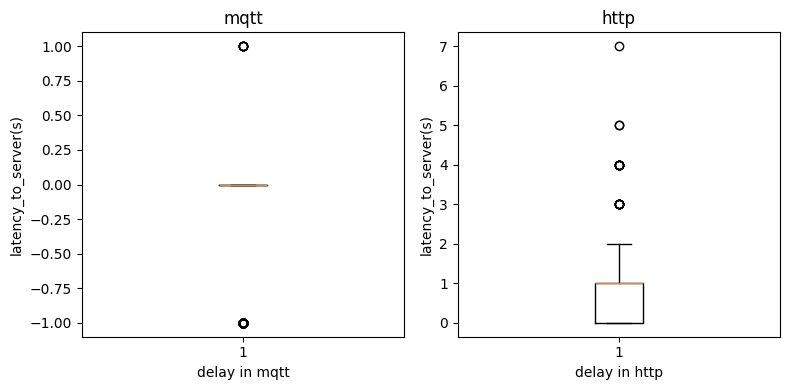

In [146]:
df_mqtt = df[df['protocol'] == 'mqtt']
df_http = df[df['protocol'] == 'http']

plot_two_boxplots(df1=df_mqtt, df2=df_http, column="latency_to_server(s)", title1="mqtt", title2="http", label1="delay in mqtt", label2="delay in http")

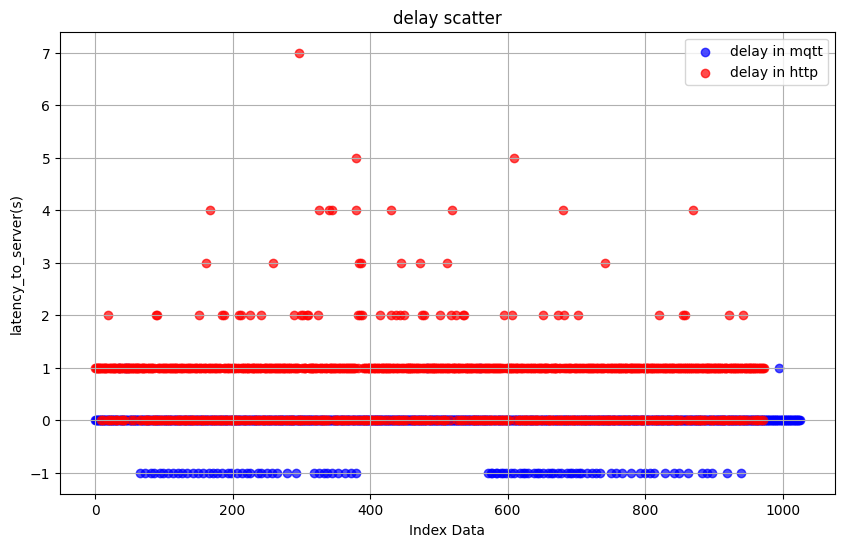

mean delay in mqtt:  -0.08187134502923976
mean delay in http:  0.7607802874743327


In [147]:
plot_two_scatter(df1=df_mqtt, df2=df_http, column="latency_to_server(s)", title="delay scatter", label1="delay in mqtt", label2="delay in http")
print("mean delay in mqtt: ", df_mqtt['latency_to_server(s)'].mean())
print("mean delay in http: ", df_http['latency_to_server(s)'].mean())